<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 

In [ ]:
df_val

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0034321,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0034322,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0034323,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,ISIC_0034324,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0034325,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
188,ISIC_0034519,0.0,1.0,0.0,0.0,0.0,0.0,0.0
189,ISIC_0034520,0.0,1.0,0.0,0.0,0.0,0.0,0.0
190,ISIC_0034521,0.0,0.0,0.0,0.0,1.0,0.0,0.0
191,ISIC_0034522,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#decode one hot label
df["Labels"] = (df.iloc[:, 1:]).idxmax(axis=1)
df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

In [ ]:
#drop one-hot column
df = df.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

In [ ]:
dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
df['FilePaths'] = dir_train + df['image'] + '.jpg'
df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'

In [ ]:
df_val

,image,Labels,FilePaths
0,ISIC_0034321,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
1,ISIC_0034322,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
2,ISIC_0034323,BCC,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
3,ISIC_0034324,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
4,ISIC_0034325,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
...,...,...,...
188,ISIC_0034519,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
189,ISIC_0034520,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
190,ISIC_0034521,BKL,/content/drive/MyDrive/PHD/Datasets/isic2018/I...
191,ISIC_0034522,NV,/content/drive/MyDrive/PHD/Datasets/isic2018/I...


Label Distribution

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

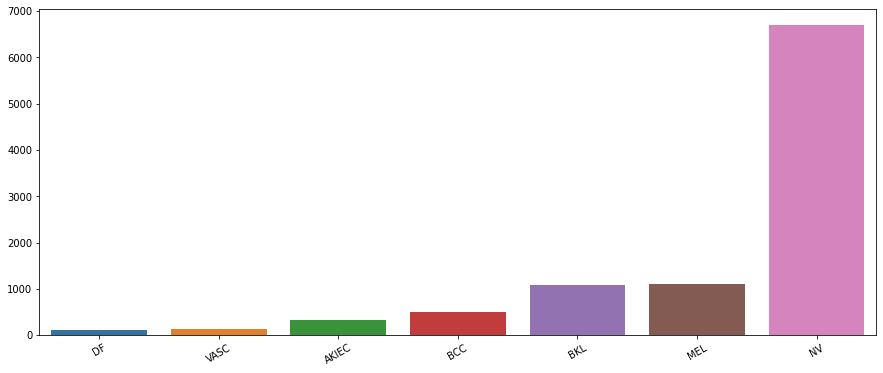

In [ ]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df['Labels'].unique())


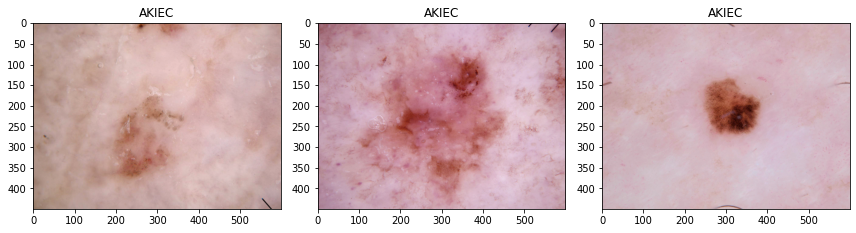

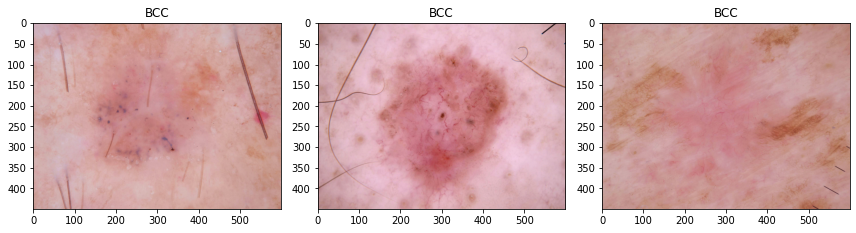

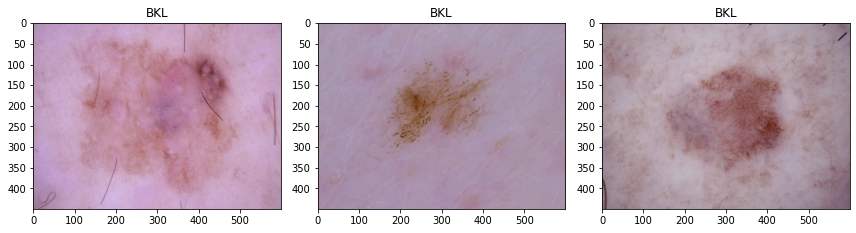

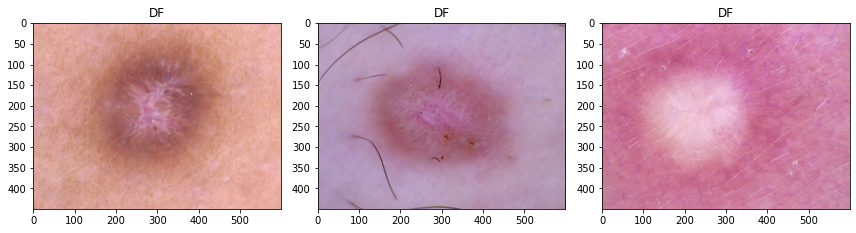

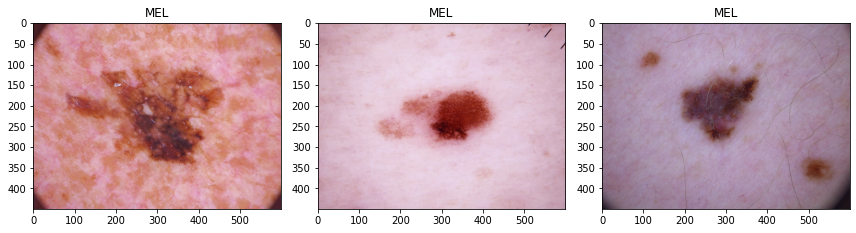

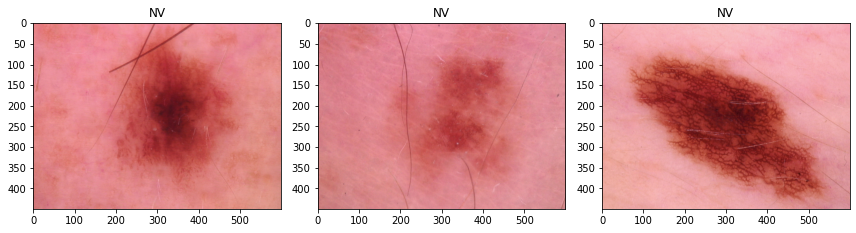

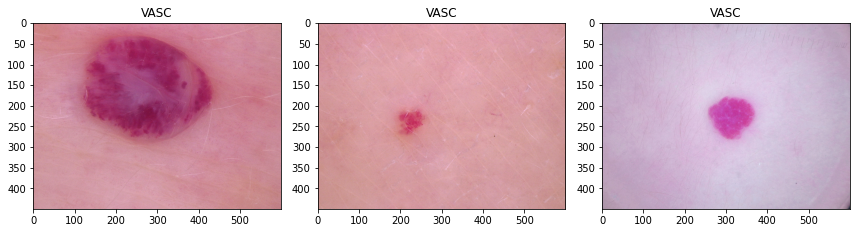

In [ ]:
# loop through labels
for label in labels:
    plot_images_per_label(df, label, 3, (12,9))

Dataset Balancer

In [ ]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


Prepare X,y

In [ ]:
# input image size
IMAGE_W = 32
IMAGE_H = 32
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
X = []
for img in df['FilePaths']:
    #img_arr = load_img(img, target_size=IMG_SIZE)
    with load_img(img, target_size=IMG_SIZE) as img_arr:
      X.append(img_to_array(img_arr))

X = np.array(X)
print(np.array(X).shape)

(10015, 32, 32, 3)


In [ ]:
X_val = []
for img in df_val['FilePaths']:
    with load_img(img, target_size=IMG_SIZE) as img_arr:
      X_val.append(img_to_array(img_arr))

X_val = np.array(X_val)
print(np.array(X_val).shape)

(193, 32, 32, 3)


In [ ]:
y = df['Labels']
y = np.array(y.values)
# summarize class distribution
from collections import Counter
counter = Counter(y)
print(counter)
print(y.shape)

Counter({'NV': 6705, 'MEL': 1113, 'BKL': 1099, 'BCC': 514, 'AKIEC': 327, 'VASC': 142, 'DF': 115})
(10015,)


In [ ]:
y_val = df_val['Labels']
y_val = np.array(y_val.values)
print(Counter(y_val))
print(y_val.shape)

Counter({'NV': 123, 'BKL': 22, 'MEL': 21, 'BCC': 15, 'AKIEC': 8, 'VASC': 3, 'DF': 1})
(193,)


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y= label_encoder.fit_transform(y)
y_val = label_encoder.fit_transform(y_val)
y

array([5, 5, 5, ..., 2, 5, 5])

Resample

In [ ]:
from imblearn.over_sampling import SMOTE
def SMOTE_Data(X, y):
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
    X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
    return X_resampled, y_resampled

In [ ]:
X, y = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X.shape)
print(y.shape)

(3744, 3072)
(3744,)


In [ ]:
counter = Counter(y)
print(counter)

Counter({7: 416, 6: 416, 5: 416, 1: 416, 2: 416, 0: 416, 3: 416, 4: 416, 8: 416})


In [ ]:
X = X.reshape(-1, IMAGE_W, IMAGE_H, 3)
print('X shape: ',X.shape)

X shape:  (3744, 32, 32, 3)


In [ ]:
X = X.astype(int)
X_val = X_val.astype(int)

In [ ]:
X[:1]

array([[[[232, 131, 135],
         [230, 120, 121],
         [234, 131, 132],
         ...,
         [237, 142, 148],
         [236, 141, 145],
         [231, 139, 140]],

        [[232, 128, 135],
         [227, 119, 116],
         [231, 123, 120],
         ...,
         [234, 138, 149],
         [233, 144, 150],
         [223, 132, 139]],

        [[226, 126, 134],
         [226, 126, 126],
         [229, 125, 126],
         ...,
         [227, 126, 140],
         [233, 141, 146],
         [235, 142, 150]],

        ...,

        [[211, 119, 122],
         [215, 121, 121],
         [217, 123, 123],
         ...,
         [218, 146, 134],
         [228, 150, 138],
         [219, 146, 137]],

        [[210, 117, 125],
         [214, 121, 131],
         [213, 123, 125],
         ...,
         [227, 150, 142],
         [221, 152, 136],
         [216, 142, 133]],

        [[209, 123, 126],
         [206, 115, 124],
         [219, 127, 130],
         ...,
         [224, 153, 135],
        

In [ ]:
y = y.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('y shape: ',y.shape)

y shape:  (10015, 1)


Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (9814, 32, 32, 3)
Remaining Data:  (201, 32, 32, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


In [ ]:
print(Counter(y_train[:,0]))

Counter({5: 6570, 4: 1091, 2: 1077, 1: 504, 0: 320, 6: 139, 3: 113})


Create and compile the model

# ResNet Transfer Learning
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [ ]:
# count of epchos
EPOCHS = 100
# number of samples/images per iteration
BATCH_SIZE = 25

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model
import numpy as np

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
# create the base pre-trained model
base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)
#predictions = Dense(9)(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# train the model on the new data for a few epochs
hst = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/100
401/401 [==============================] - 9s 15ms/step - loss: 1.3061 - accuracy: 0.6680 - val_loss: 0.8602 - val_accuracy: 0.7254
Epoch 2/100
401/401 [==============================] - 5s 13ms/step - loss: 0.8201 - accuracy: 0.7072 - val_loss: 0.7247 - val_accuracy: 0.7254
Epoch 3/100
401/401 [==============================] - 5s 13ms/step - loss: 0.7800 - accuracy: 0.7236 - val_loss: 0.7750 - val_accuracy: 0.7306
Epoch 4/100
401/401 [==============================] - 5s 13ms/step - loss: 0.7470 - accuracy: 0.7324 - val_loss: 0.7354 - val_accuracy: 0.7202
Epoch 5/100
401/401 [==============================] - 5s 13ms/step - loss: 0.7280 - accuracy: 0.7344 - val_loss: 0.7757 - val_accuracy: 0.7150
Epoch 6/100
401/401 [==============================] - 5s 13ms/step - loss: 0.7148 - accuracy: 0.7453 - val_loss: 0.7440 - val_accuracy: 0.7202
Epoch 7/100
401/401 [==============================] - 5s 13ms/step - loss: 0.7032 - accuracy: 0.7465 - val_loss: 0.6426 - val_accuracy:

In [ ]:
model.save('/content/drive/MyDrive/models')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/models/assets


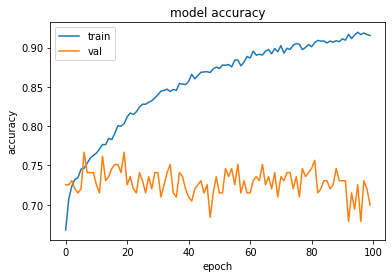

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# we chose to train the top 2 resnet blocks, i.e. we will freeze
# the first 49 layers and unfreeze the rest:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hst2 = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val))

Epoch 1/100
393/393 [==============================] - 10s 16ms/step - loss: 0.4810 - accuracy: 0.8807 - val_loss: 2.0743 - val_accuracy: 0.7254
Epoch 2/100
393/393 [==============================] - 5s 14ms/step - loss: 0.3534 - accuracy: 0.8950 - val_loss: 1.8436 - val_accuracy: 0.7306
Epoch 3/100
393/393 [==============================] - 5s 14ms/step - loss: 0.2979 - accuracy: 0.9048 - val_loss: 1.7317 - val_accuracy: 0.7254
Epoch 4/100
393/393 [==============================] - 5s 14ms/step - loss: 0.2652 - accuracy: 0.9114 - val_loss: 1.8057 - val_accuracy: 0.7202
Epoch 5/100
393/393 [==============================] - 6s 14ms/step - loss: 0.2609 - accuracy: 0.9135 - val_loss: 1.7292 - val_accuracy: 0.7202
Epoch 6/100
393/393 [==============================] - 6s 15ms/step - loss: 0.2380 - accuracy: 0.9184 - val_loss: 1.6553 - val_accuracy: 0.7358
Epoch 7/100
393/393 [==============================] - 5s 14ms/step - loss: 0.2367 - accuracy: 0.9193 - val_loss: 1.6242 - val_accuracy

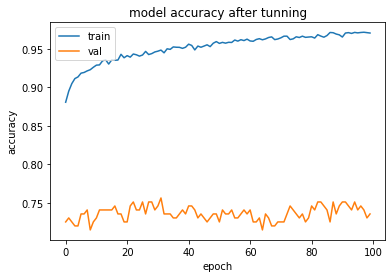

In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['accuracy'])
plt.plot(hst2.history['val_accuracy'])
plt.title('model accuracy after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# accuracy
print(f'Train Accuracy: {hst2.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst2.history["val_accuracy"][-1:][0] * 100:.2f}')
# loss
print(f'Train Loss: {hst2.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst2.history["val_loss"][-1:][0] * 100:.2f}')

Train Accuracy: 97.05
Val Accuracy: 73.58
Train Loss: 8.45
Val Loss: 168.38


Load test data

In [ ]:
X_test = load_data('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

Print head data

In [ ]:
X_test.head(3)

,FilePaths,Labels
0,Skin cancer ISIC The International Skin Imagin...,vascular lesion
1,Skin cancer ISIC The International Skin Imagin...,pigmented benign keratosis
2,Skin cancer ISIC The International Skin Imagin...,squamous cell carcinoma


In [ ]:
print('Test Data: ', X_test.shape)

# ordered count of rows per unique label
X_test['Labels'].value_counts(ascending=True)

Test Data:  (118, 2)


vascular lesion                3
seborrheic keratosis           3
pigmented benign keratosis    16
squamous cell carcinoma       16
actinic keratosis             16
melanoma                      16
nevus                         16
dermatofibroma                16
basal cell carcinoma          16
Name: Labels, dtype: int64

Preprocess test image

In [ ]:
X_test_arr = []
for img in X_test['FilePaths']:
    loaded_img = load_img(img, target_size=IMG_SIZE)
    img_arr = img_to_array(loaded_img)
    X_test_arr.append(img_arr)
    
print(np.array(X_test_arr).shape)  
y_test = X_test['Labels']
X_test = X_test_arr

y_test = np.array(y_test.values)
X_test = np.array(X_test)

(118, 224, 224, 3)


In [ ]:
#resampling test set

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42, k_neighbors=2)
X_test, y_test = sm.fit_resample(X_test.reshape((-1, IMAGE_W * IMAGE_H * 3)), y_test)
X_test.reshape(-1, IMAGE_W, IMAGE_H, 3)
print(X_test.shape)
print(y_test.shape)

(144, 150528)
(144,)


In [ ]:
X_test

array([[171.     , 149.     , 170.     , ...,  37.     ,  34.     ,
         53.     ],
       [172.     , 135.     , 169.     , ..., 173.     , 138.     ,
        171.     ],
       [184.     , 149.     , 155.     , ..., 198.     , 158.     ,
        166.     ],
       ...,
       [190.80458, 136.39708, 150.79555, ..., 131.82196,  90.41307,
        102.2114 ],
       [204.09334, 129.02664, 138.69998, ..., 195.18666, 128.88664,
        135.74664],
       [204.05249, 128.57738, 138.39366, ..., 195.10498, 128.49864,
        135.4199 ]], dtype=float32)

In [ ]:
X_test = X_test.reshape(-1, IMAGE_W, IMAGE_H, 3)

In [ ]:
y_test = y_test.reshape(-1,1)
y_test= label_encoder.fit_transform(y_test)
y_test

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([8, 5, 7, 0, 3, 5, 4, 2, 1, 0, 5, 5, 2, 4, 6, 1, 0, 5, 2, 0, 4, 3,
       4, 7, 3, 5, 2, 2, 0, 7, 1, 1, 3, 0, 4, 0, 1, 2, 5, 3, 0, 1, 2, 7,
       3, 2, 4, 7, 3, 0, 1, 7, 1, 3, 2, 7, 4, 7, 7, 1, 7, 3, 8, 6, 2, 5,
       5, 0, 5, 4, 4, 3, 7, 5, 3, 2, 7, 3, 0, 8, 2, 1, 1, 3, 1, 0, 4, 7,
       2, 7, 4, 1, 0, 7, 2, 5, 4, 3, 3, 3, 1, 2, 5, 0, 0, 4, 0, 2, 5, 5,
       4, 5, 7, 1, 4, 4, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [ ]:
#y_test = y_test.reshape(-1,1)

In [ ]:
#X_test = X_test.astype('float32') / 255.

Evaluate model againts test data

In [ ]:
res = model.evaluate(X_test,y_test)

7/7 [==============================] - 1s 15ms/step - loss: 3.5914 - accuracy: 0.4509


The accuracy

In [ ]:
# accuracy
print(f'Train Accuracy: {hst2.history["accuracy"][-1:][0] * 100:.2f}')
print(f'Val Accuracy: {hst2.history["val_accuracy"][-1:][0] * 100:.2f}')
print(f'Test Accuracy: {res[1] * 100:.2f}')
# loss
print(f'Train Loss: {hst2.history["loss"][-1:][0] * 100:.2f}')
print(f'Val Loss: {hst2.history["val_loss"][-1:][0] * 100:.2f}')
print(f'Test Loss: {res[0] * 100:.2f}')

Train Accuracy: 95.73
Val Accuracy: 73.07
Test Accuracy: 45.09
Train Loss: 9.05
Val Loss: 161.83
Test Loss: 359.14


Calculate y_pred from training and testing for analysis

In [ ]:
# predicted labels
Y_pred = model.predict(X_val)
print("Y_pred", Y_pred.shape)
# rounded labels
y_pred = np.argmax(Y_pred, axis=1)
print("y_pred", y_pred.size)

Y_pred (193, 9)
y_pred 193


In [ ]:
# predicted labels
Y_pred2 = model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

Y_pred2 (224, 9)
y_pred2 224


Calculate y_true

In [ ]:
# true labels
#y_true = X_test.classes
print("y_pred", len(y_pred))
# label classes
#class_labels = list(X_test.class_indices.keys())
print("labels", len(y_val))

y_pred 193
labels 193


In [ ]:
y_pred[:10]

array([5, 5, 0, 5, 5, 5, 5, 5, 5, 5])

F1 Score

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
print('Score on val data: ',precision_recall_fscore_support(y_val, y_pred, average='macro'))
#print('Score on test data: ',precision_recall_fscore_support(y_test, y_pred2, average='macro'))

Score on val data:  (0.5306913674560734, 0.3937889346425932, 0.42846503137856523, None)


The confusion metric

In [ ]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_val, y_pred)

print(cf_matrix)

[[  3   2   2   0   0   1   0]
 [  5   6   3   1   0   0   0]
 [  2   0   8   0   3   9   0]
 [  0   0   0   0   0   1   0]
 [  0   1   4   1   7   8   0]
 [  1   0   3   1   1 117   0]
 [  0   2   0   0   0   0   1]]


In [ ]:
cf_matrix2 = confusion_matrix(y_test, y_pred2)
print(cf_matrix2)

[[ 3  2  1  0  4  0  0  1  0]
 [ 2 16  0  4  0  7  0  6  3]
 [ 2  1  4  1  0  0  0  1  0]
 [ 0  2  0 25  4  5  7  1  0]
 [ 5  1  0  6 19  4  0  1  0]
 [ 3 10  2  4  1 18  1  5  2]
 [ 0  0  0  8  0  0  0  0  0]
 [ 4  5  0  2  0  1  0  6  0]
 [ 0  2  0  0  1  0  0  1 10]]


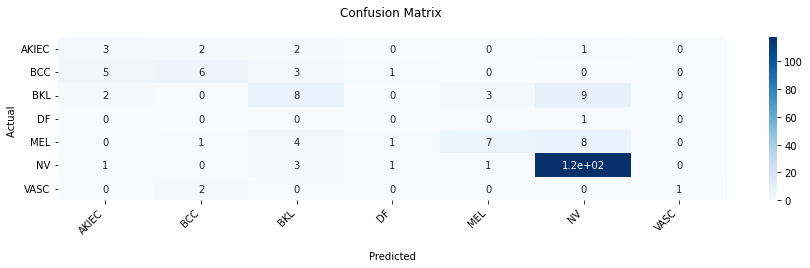

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

[Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'DF'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV'),
 Text(0, 0, 'VASC')]

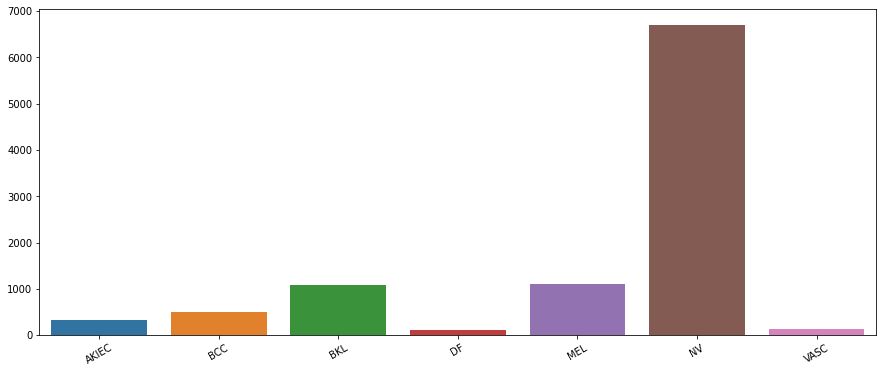

In [ ]:
# ordered count of rows per unique label
labels_count = df['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)